<a href="https://colab.research.google.com/github/pabloknappo/hello-world/blob/main/notebooks/wind_turbine_blade_fault_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One line to use as terminal if needed.

In [ ]:
!pip install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import required libraries.

In [ ]:
import pandas as pd
import numpy as np
import glob
import pickle
from tqdm import tqdm
from scipy import signal

In [ ]:
# mount gooogle drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA
First it is needed to load data. Measurements are stored in .xlsx files. Every files consists data related to one wind speed and one type of damage. During the experiments three types of wind speeds were used:


*   20 Hz
*   30 Hz
*   40 Hz
*   50 Hz

These values are related to value set on inverters, which were used to control fans, that were creating wind.

Files are loaded from .xlsx files to dataframes. Then dataframes are stored in dictionary where key is related to filename.

## HOW DATA WAS COLLECTED?

Data was measured with three axis piezoelectric accelerometer sensor.
Sampling frequency for all of the measurements was set to 20 kHz.




In [ ]:
folder_path =  r"/content/drive/MyDrive/Turbina _wiatrowa_5G/poprawione" # path to folder where data is stored
files_list = glob.glob(folder_path + '/*.xlsx')

In [ ]:
df_container = dict([]) # create empty dictionary to store dataframes
for filename in tqdm(files_list):
  dict_key = filename.split('/')[-1].split('.')[0] # prepare proper dict key, e.x. 20hz_damaged
  df_container[dict_key] = pd.read_excel(filename)
  df_container[dict_key] = df_container[dict_key].drop(columns=['Untitled', 'Untitled 1'])
  df_container[dict_key] = df_container[dict_key].rename(columns={'Wind speed voltage' : 'wind_speed', 'x' : 'x_axis', 'y' : 'y_axis', 'z' : 'z_axis'})

 62%|██████▏   | 13/21 [15:57<09:48, 73.61s/it]

In [ ]:
df_container.keys()

dict_keys(['20hz_3wady', '20hz_bezuszkodzenia', '20hz_przeciete', '20hz_spiłowane', '20hz_zeszlifowane', '30hz_3wady', '30hz_bezuszkodzenia', '30hz_przeciete', '30hz_spiłowane', '30hz_zeszlifowane', '40hz_3wady', '40hz_3wady_v2wtf', '40hz_bezuszkodzenia', '40hz_przeciete', '40hz_spiłowane', '40hz_zeszlifowane', '50hz_3wady', '50hz_bezuszkodzenia', '50hz_przeciete', '50hz_spiłowane', '50hz_zeszlifowane'])

In [ ]:
temp = df_container # save data in temporary container in case of some mistake

In [ ]:
temp['40hz_3wady'] = pd.merge(temp['40hz_3wady'], temp['40hz_3wady_v2wtf'])
temp.pop('40hz_3wady_v2wtf', None)

,wind_speed,x_axis,y_axis,z_axis
0,0.067901,-0.101470,-0.154090,0.007914
1,0.058338,-0.111355,-0.153458,0.028318
2,0.057700,-0.120602,-0.161042,0.045534
3,0.062482,-0.126023,-0.170522,0.056692
4,0.057381,-0.119646,-0.184426,0.059880
...,...,...,...,...
1048570,-0.002870,0.081240,-0.142081,0.234272
1048571,-0.003507,0.084748,-0.134181,0.220563
1048572,-0.000319,0.080602,-0.126913,0.204941
1048573,-0.000638,0.069442,-0.129441,0.174016


In [ ]:
temp.keys()

dict_keys(['20hz_3wady', '20hz_bezuszkodzenia', '20hz_przeciete', '20hz_spiłowane', '20hz_zeszlifowane', '30hz_3wady', '30hz_bezuszkodzenia', '30hz_przeciete', '30hz_spiłowane', '30hz_zeszlifowane', '40hz_3wady', '40hz_bezuszkodzenia', '40hz_przeciete', '40hz_spiłowane', '40hz_zeszlifowane', '50hz_3wady', '50hz_bezuszkodzenia', '50hz_przeciete', '50hz_spiłowane', '50hz_zeszlifowane'])



---


**Dataframe is now ready. To make returning to work faster we can save it as pickle file in ours Google Drive.**

---



In [ ]:
with open('/content/drive/MyDrive/Turbina _wiatrowa_5G/df_container.pickle', 'wb') as handle:
    pickle.dump(df_container, handle, protocol=pickle.HIGHEST_PROTOCOL)




---


**To resume work load df_container saved in pickle by running below code.**


---



In [ ]:

with open('/content/drive/MyDrive/Turbina _wiatrowa_5G/poprawione/df_container.pickle', 'rb') as handle:
    temp = pickle.load(handle)

In [ ]:
fs = 20000 # sampling frequency equals to 20 kHz

Tutaj będzie część gdzie wybieramy trzy piki największe. Trzeba z teo stworzyć dataset

x_peak1 .....| .... z_peak ... | .... wind_speed_peak

---


[ampiltude, freq] [ampiltude, freq] [ampiltude, freq]

Tutaj trzeba zaimplementować to co wyżej ta żeby zapisało do w datafarmie

In [ ]:
batch_len = fs # set constant batch length

# create empty arrays to fill in
x_peaks_result = np.zeros((0,3))
x_freq_result = np.zeros((0,3))

y_peaks_result = np.zeros((0,3))
y_freq_result = np.zeros((0,3))

z_peaks_result = np.zeros((0,3))
z_freq_result = np.zeros((0,3))

wind_peaks_result = np.zeros((0,3))
wind_freq_result = np.zeros((0,3))

labels = []

j = 0

for key in tqdm(temp.keys()):
  for (name, data) in temp[key].iteritems():

    batch = data[0:batch_len] #first batch for loop

    numel = len(data) #length of measurement file
    max_loop = (numel)//batch_len # number of loop iterations

    temp_peaks_result = np.zeros((max_loop,3))
    temp_freq_result = np.zeros((max_loop,3))

    for i in range(0,max_loop):
      freq_spectrum = np.abs(np.fft.rfft(batch))
      f = np.fft.rfftfreq(len(batch), 1/fs)

      freq, peaks = signal.find_peaks(freq_spectrum, height=np.mean(freq_spectrum))
      ix = np.argsort(peaks['peak_heights'])

      # save max peaks in temp array
      max_peaks = peaks['peak_heights'][ix][-3:]
      temp_peaks_result[i,:] = max_peaks

      # save max freq in temp array
      max_freq = freq[ix][-3:]
      temp_freq_result[i,:] = max_freq

      if name == 'x_axis': # fill only once
        labels.append(j)

      # move batch
      batch = data[batch_len*i:(batch_len*i+batch_len)]


    if name == 'x_axis':
      x_peaks_result = np.append(x_peaks_result, temp_peaks_result, axis=0)
      x_freq_result = np.append(x_freq_result, temp_freq_result, axis=0)
    elif name == 'y_axis':
      y_peaks_result = np.append(y_peaks_result, temp_peaks_result, axis=0)
      y_freq_result = np.append(y_freq_result, temp_freq_result, axis=0)
    elif name == 'z_axis':
      z_peaks_result = np.append(z_peaks_result, temp_peaks_result, axis=0)
      z_freq_result = np.append(z_freq_result, temp_freq_result, axis=0)
    elif name == 'wind_speed':
      wind_peaks_result = np.append(wind_peaks_result, temp_peaks_result, axis=0)
      wind_freq_result = np.append(wind_freq_result, temp_freq_result, axis=0)
  j = j + 1

100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


In [ ]:
labels = np.array(labels)
labels.shape

(1040,)

In [ ]:
for key in temp.keys():
  print(key)

20hz_3wady
20hz_bezuszkodzenia
20hz_przeciete
20hz_spiłowane
20hz_zeszlifowane
30hz_3wady
30hz_bezuszkodzenia
30hz_przeciete
30hz_spiłowane
30hz_zeszlifowane
40hz_3wady
40hz_bezuszkodzenia
40hz_przeciete
40hz_spiłowane
40hz_zeszlifowane
50hz_3wady
50hz_bezuszkodzenia
50hz_przeciete
50hz_spiłowane
50hz_zeszlifowane


In [ ]:
label_mapper = {
    0 : '20hz_3wady',
    1 : '20hz_bezuszkodzenia',
    2 : '20hz_przeciete',
    3 : '20hz_spiłowane',
    4 : '20hz_zeszlifowane',
    5 : '30hz_3wady',
    6 : '30hz_bezuszkodzenia',
    7 : '30hz_przeciete',
    8 : '30hz_spiłowane',
    9 : '30hz_zeszlifowane',
    10 : '40hz_3wady',
    11 : '40hz_bezuszkodzenia',
    12 : '40hz_przeciete',
    13 : '40hz_spiłowane',
    14 : '40hz_zeszlifowane',
    15 : '50hz_3wady',
    16 : '50hz_bezuszkodzenia',
    17 : '50hz_przeciete',
    18 : '50hz_spiłowane',
    19 : '50hz_zeszlifowane'
}

5_label_mapper =  {
        0 : '3 faults',
        1 : 'no damage',
        2 : 'cut',
        3 : 'filed',
        4 : 'grinded'
        }

In [ ]:
# map labels to consider only damages types not speeds
labels[labels == 5] = 0
labels[labels == 10] = 0
labels[labels == 15] = 0

labels[labels == 6] = 1
labels[labels == 11] = 1
labels[labels == 16] = 1


labels[labels == 7] = 2
labels[labels == 12] = 2
labels[labels == 17] = 2

labels[labels == 8] = 3
labels[labels == 13] = 3
labels[labels == 18] = 3

labels[labels == 9] = 4
labels[labels == 14] = 4
labels[labels == 19] = 4

labels = np.array(labels)
labels.shape

(1040,)

In [ ]:
# stack all results horizontally to create one common dataset
dataset = np.hstack((x_peaks_result,x_freq_result,y_peaks_result,y_freq_result,z_peaks_result,z_freq_result,wind_peaks_result,wind_freq_result))


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300


# X = np.transpose(X)
# print("Data array shape: " + str(X.shape))
# print("Labels array shape: " + str(Y.shape))

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

In [ ]:
dataset.shape

(1040, 24)

In [ ]:

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(832, 24)
(832,)
(208, 24)
(208,)


In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
num_classes = len(np.unique(y_train))
print(num_classes)

5


In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.Dropout(0.2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(0.2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.Dropout(0.2)(conv3)


    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    gap = keras.layers.Dropout(0.5)(gap)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])


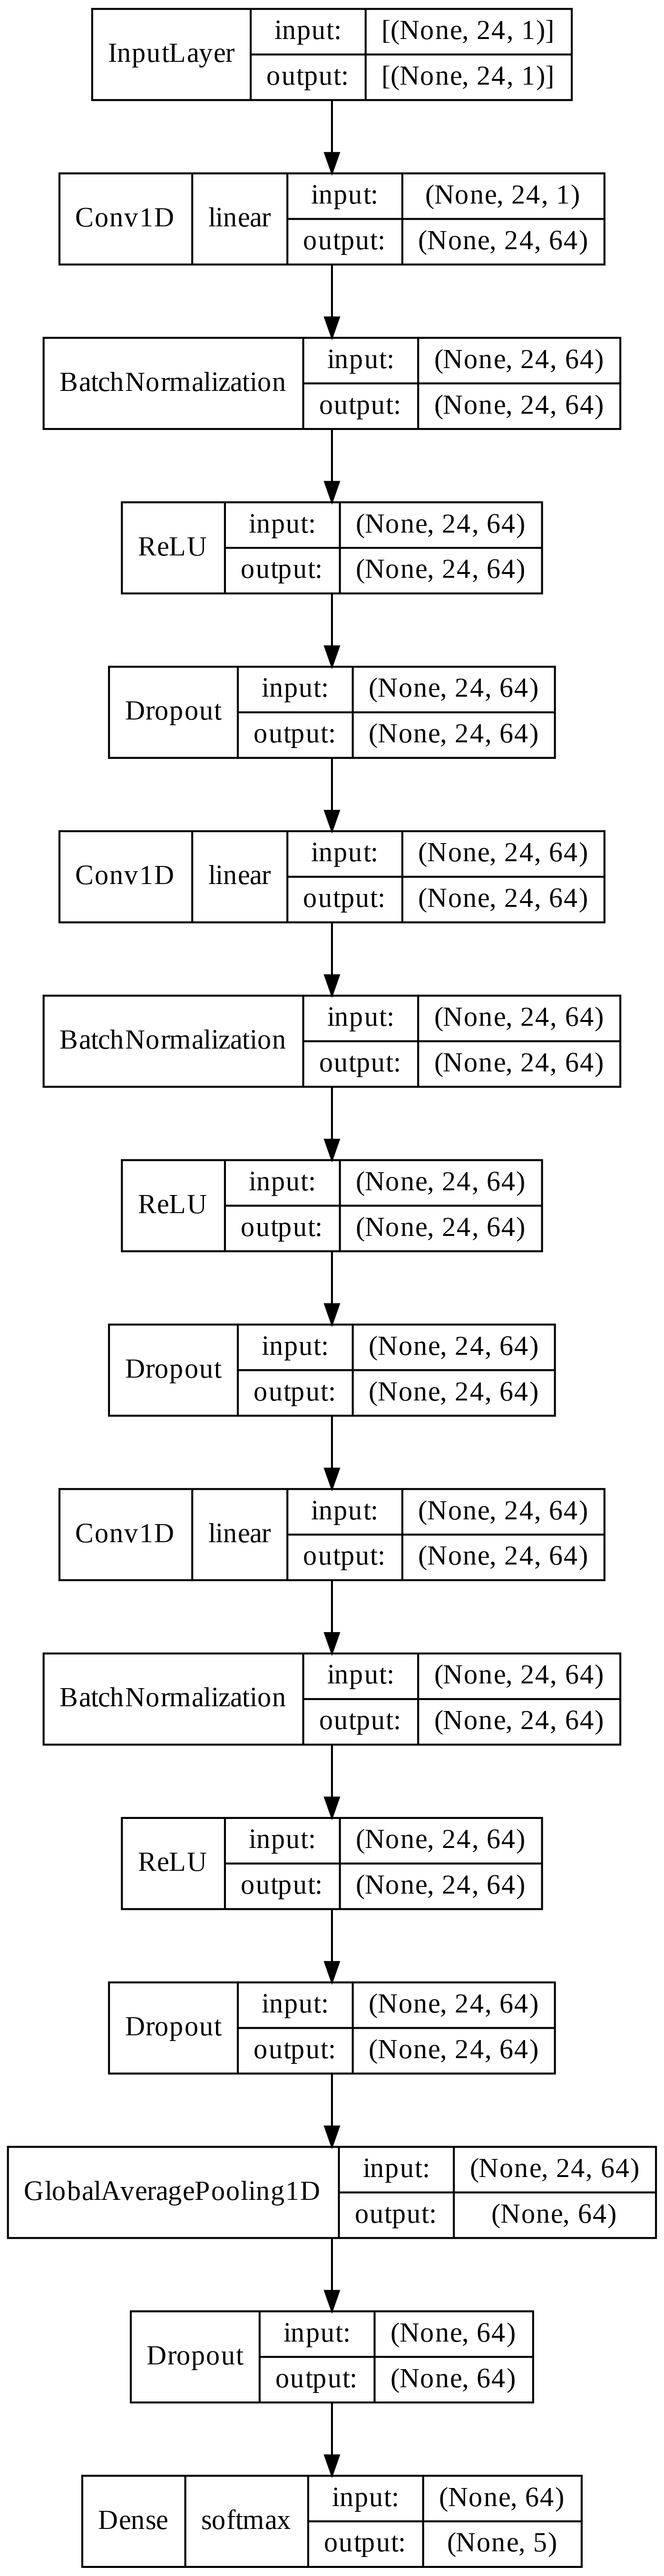

In [ ]:
keras.utils.plot_model(model,
                       to_file="model.png",
                      show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=300,
    layer_range=None,
    show_layer_activations=True,
    )

In [ ]:
"""
## Train the model
"""

epochs = 100000
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=1000, min_lr=0.000001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5000, verbose=1),
]

from tensorflow.keras.optimizers import SGD
opt = SGD()

model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=2,
)

Streaming output truncated to the last 5000 lines.
21/21 - 0s - loss: 0.1025 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.2993 - val_sparse_categorical_accuracy: 0.8982 - lr: 1.0000e-06 - 295ms/epoch - 14ms/step
Epoch 9696/100000
21/21 - 0s - loss: 0.1016 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.2593 - val_sparse_categorical_accuracy: 0.9102 - lr: 1.0000e-06 - 285ms/epoch - 14ms/step
Epoch 9697/100000
21/21 - 0s - loss: 0.0971 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.9102 - lr: 1.0000e-06 - 289ms/epoch - 14ms/step
Epoch 9698/100000
21/21 - 0s - loss: 0.1019 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.3046 - val_sparse_categorical_accuracy: 0.8982 - lr: 1.0000e-06 - 301ms/epoch - 14ms/step
Epoch 9699/100000
21/21 - 0s - loss: 0.0974 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.3317 - val_sparse_categorical_accuracy: 0.8922 - lr: 1.0000e-06 - 282ms/epoch - 13ms/step
Epoch 9700/100000
21/21 - 0s - loss: 

7/7 [==============================] - 0s 4ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.9471
Test accuracy 0.9471153616905212
Test loss 0.1260455697774887


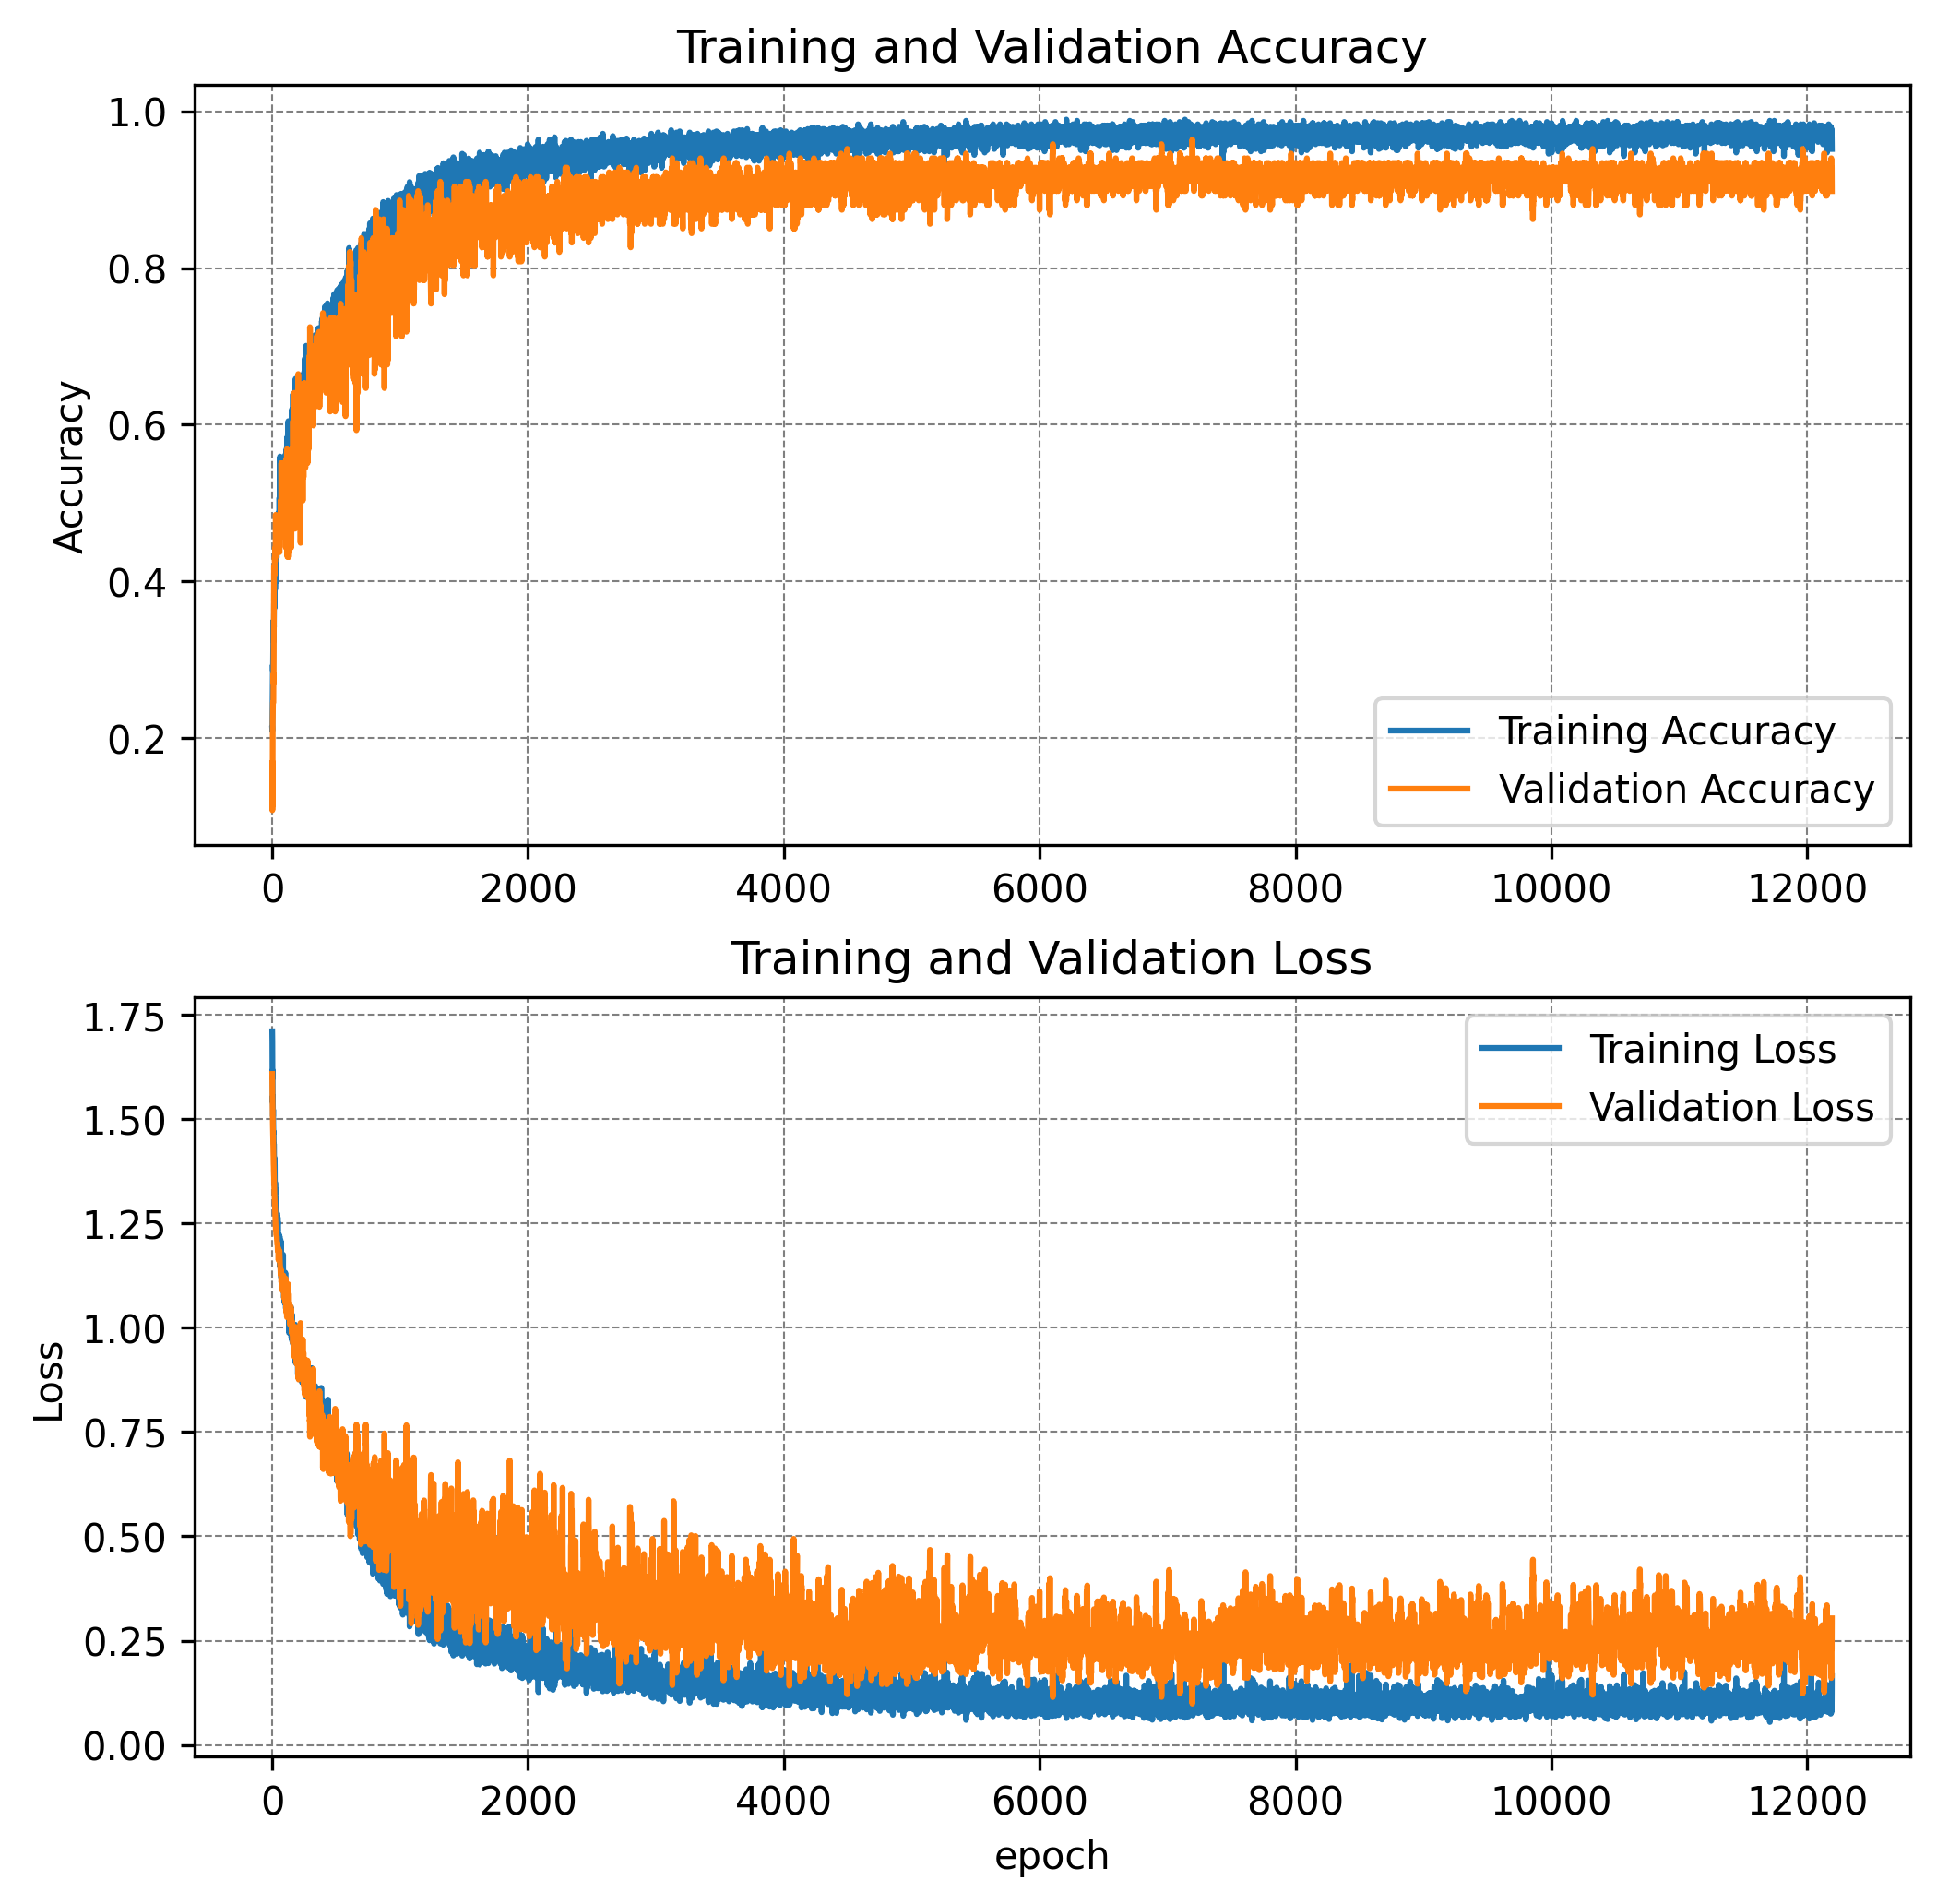

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

"""
## Plot the model's training and validation loss
"""

metric = "sparse_categorical_accuracy"

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Training and Validation Accuracy")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc="best")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)


metric = "loss"
plt.subplot(2, 1, 2)
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["Training Loss", "Validation Loss"], loc="best")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig('uczenie_wykres_szeregi.png')
plt.show()

In [ ]:
predictions = model.predict(x_test)
pred_ix = np.argmax(predictions, axis=1)

7/7 [==============================] - 1s 10ms/step



Sample idea to map labels in the future if it will be needed.
```
labels = {0: 'fail', 1: 'no_fail'}

out = [0, 0, 0, 1, 0, 1]
out_n = []
for item in out:
    out_n.append(labels[item])
```



In [ ]:
from sklearn import metrics

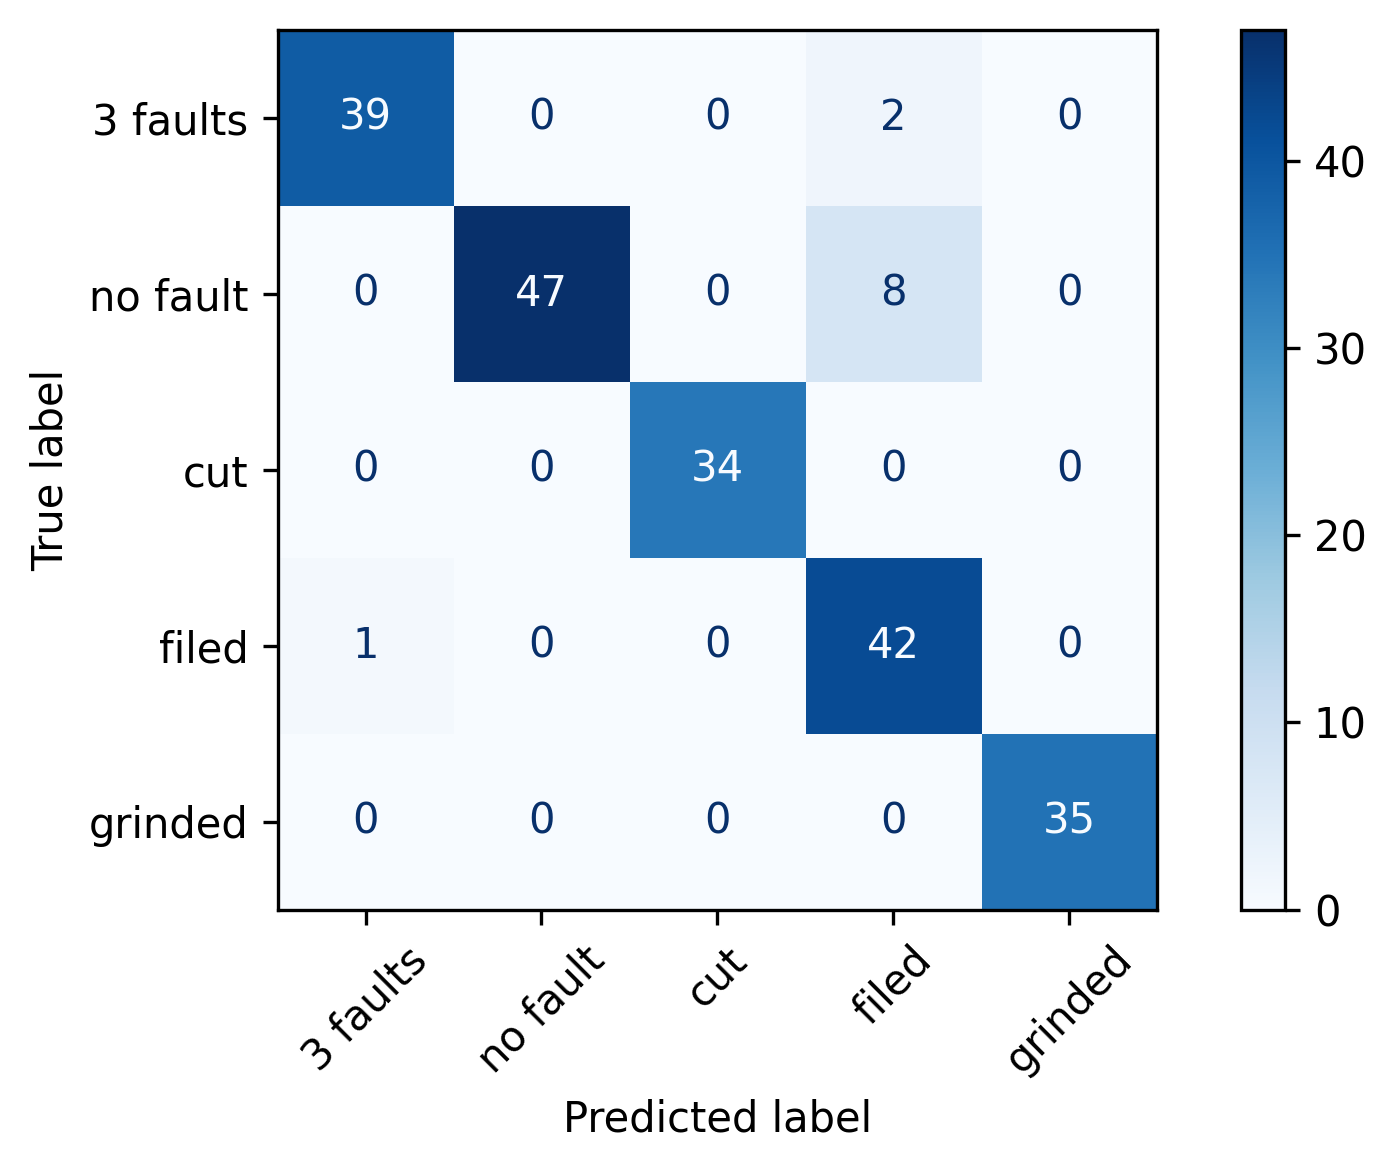

In [ ]:

cm = metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred_ix,
                                        xticks_rotation=45,
                                        cmap=plt.cm.Blues,
                                        display_labels=['3 faults', 'no fault', 'cut', 'filed', 'grinded'])
plt.tight_layout()
plt.savefig('conf_mat.png')


In [ ]:
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
